In [556]:
import numpy as np
import pandas as pd
import sys
import argparse
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use("ggplot")
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR
import math
import scipy.stats 
import copy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures

In [557]:
parser = argparse.ArgumentParser(description='Process display arguments')
parser.add_argument("-f", "--jupyter-json")
parser.add_argument("-design-matrix", "--design-matrix", default="covariate_normalized.txt")
parser.add_argument("-num-genes", "--num-genes", default=100)
parser.add_argument("-original-design", "--original", 
                   default="/project2/gilad/bstrober/ipsc_differentiation/preprocess/processed_total_expression/rpkm.txt")
args = parser.parse_args()

num_genes = args.num_genes

def gen_clean_matrix(filepath):
    mt = pd.DataFrame(np.genfromtxt(filepath, dtype=str))
    mt.columns = mt.iloc[0]
    mt = mt.reindex(mt.index.drop(0))
    mt.set_index(mt[mt.columns[0]], inplace=True, drop=True)
    del mt[mt.columns[0]]
    mt.columns.name = None
    return mt.apply(pd.to_numeric)

df = pd.read_csv(args.design_matrix)
df.set_index("Gene_id", inplace=True)
df = df.transpose()

original_df = gen_clean_matrix(args.original)
original_df = original_df.transpose()

df = df[original_df.var().nlargest(num_genes).index]

samples = list(df.index)
cell_lines = set()
for sample in samples:
    cell_lines.add(sample.split("_")[0])
cell_lines = sorted(list(cell_lines))

In [419]:
index_list = ["18499_" + str(x) for x in range(16)]
test_gene = pd.DataFrame(df.loc[index_list, "ENSG00000106631"])
test_gene.index = test_gene.index.map(lambda x: int(x.split("_")[1]))

Predict a gene (ENSG00000106631, 18499) using Gaussian Processes

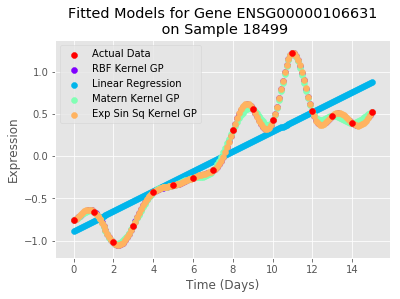

In [518]:
c = cm.rainbow(np.linspace(0, 1, 5))
rbf_gp = GaussianProcessRegressor().fit(pd.DataFrame(test_gene.index).as_matrix(), test_gene.loc[0:].as_matrix())
rbf_gp_plot = plt.scatter(np.linspace(0, 15, 151).reshape(-1, 1), rbf_gp.predict(np.linspace(0, 15, 151).reshape(-1, 1)), color=c[0])

lr = linear_model.LinearRegression().fit(pd.DataFrame(test_gene.index).as_matrix(), test_gene.loc[0:].as_matrix())
lr_plot = plt.scatter(np.linspace(0, 15, 151).reshape(-1, 1), lr.predict(np.linspace(0, 15, 151).reshape(-1, 1)), color=c[1])

mat_gp = GaussianProcessRegressor(kernel=Matern()).fit(pd.DataFrame(test_gene.index).as_matrix(), test_gene.loc[0:].as_matrix())
mat_gp_plot = plt.scatter(np.linspace(0, 15, 151).reshape(-1, 1), mat_gp.predict(np.linspace(0, 15, 151).reshape(-1, 1)), color=c[2])

exp_sine_sq_gp = GaussianProcessRegressor(kernel=ExpSineSquared()).fit(pd.DataFrame(test_gene.index).as_matrix(), test_gene.loc[0:].as_matrix())
exp_sine_sq_gp_plot = plt.scatter(np.linspace(0, 15, 151).reshape(-1, 1), exp_sine_sq_gp.predict(np.linspace(0, 15, 151).reshape(-1, 1)), color=c[3])

actual_plot = plt.scatter(pd.DataFrame(test_gene.index).as_matrix(), test_gene.loc[0:].as_matrix(), color=c[4])

plt.legend([actual_plot, rbf_gp_plot, lr_plot, mat_gp_plot, exp_sine_sq_gp_plot], ['Actual Data', 'RBF Kernel GP', "Linear Regression", "Matern Kernel GP", "Exp Sin Sq Kernel GP"])
plt.title("Fitted Models for Gene ENSG00000106631\n on Sample 18499")
plt.xlabel("Time (Days)")
plt.ylabel("Expression")
plt.savefig("plots/gp_1.png", dpi=300)

In [496]:
new_test_gene = test_gene.drop(test_gene.index[[1, 3, 5, 7, 9, 11, 13, 15]])

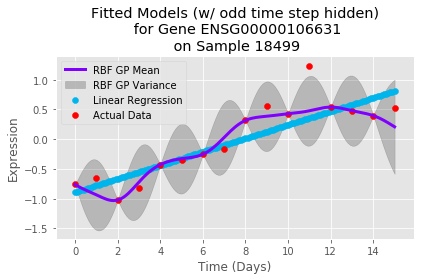

In [519]:
c = cm.rainbow(np.linspace(0, 1, 5))
rbf_gp = GaussianProcessRegressor().fit(pd.DataFrame(new_test_gene.index).as_matrix(), new_test_gene.loc[0:].as_matrix())
X = np.linspace(0, 15, 151).reshape(-1, 1)
y_mean, y_std = rbf_gp.predict(X, return_std=True)
X = X.flatten()
y_mean = y_mean.flatten()
y_std = y_std.flatten()
rbf_gp_plot = plt.plot(X, y_mean, 'k', lw=3, zorder=9, color=c[0], label="RBF GP Mean")
rbf_var_plot = plt.fill_between(X, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k', label="RBF GP Variance")

lr = linear_model.LinearRegression().fit(pd.DataFrame(new_test_gene.index).as_matrix(), new_test_gene.loc[0:].as_matrix())
lr_plot = plt.scatter(np.linspace(0, 15, 151).reshape(-1, 1), lr.predict(np.linspace(0, 15, 151).reshape(-1, 1)), color=c[1], label="Linear Regression")


actual_plot = plt.scatter(pd.DataFrame(test_gene.index).as_matrix(), test_gene.loc[0:].as_matrix(), color=c[4], label="Actual Data")
plt.legend()
plt.title("Fitted Models (w/ odd time step hidden)\n for Gene ENSG00000106631\n on Sample 18499")
plt.xlabel("Time (Days)")
plt.ylabel("Expression")
plt.tight_layout()
plt.savefig("plots/gp_hidden.png", dpi=300)

Predict a gene (ENSG00000106631, 18499) using Linear Regression

In [520]:
rbf_results = []
lr_results = []
mat_results = []
exp_sine_sq_results = []

for i in range(16):
    test_gene_i = test_gene[test_gene.index != i]
    time = pd.DataFrame(test_gene_i.index).as_matrix()
    y = test_gene_i.loc[0:].as_matrix()
    
    rbf = GaussianProcessRegressor(1.0 * RBF(1)).fit(time, y)
    rbf_results.append(float(rbf.predict(i)))
    
    lr = linear_model.LinearRegression().fit(time, y)
    lr_results.append(float(lr.predict(i)))
    
    mat = GaussianProcessRegressor(kernel=Matern()).fit(time, y)
    mat_results.append(float(mat.predict(i)))
    
    exp_sine_sq_gp = GaussianProcessRegressor(kernel=ExpSineSquared()).fit(time, y)
    exp_sine_sq_results.append(float(exp_sine_sq_gp.predict(i)))


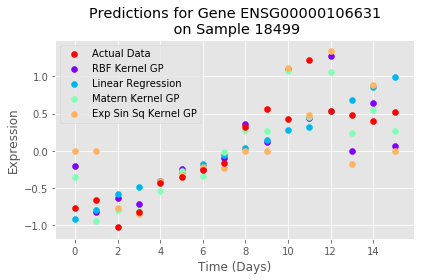

In [522]:
rbf_plot = plt.scatter(range(16), rbf_results, color=c[0])
lr_plot = plt.scatter(range(16), lr_results, color=c[1])
mat_plot = plt.scatter(range(16), mat_results, color=c[2])
exp_sine_sq_plot = plt.scatter(range(16), exp_sine_sq_results, color=c[3])
actual_plot = plt.scatter(pd.DataFrame(test_gene.index).as_matrix(), test_gene.loc[0:].as_matrix(), color=c[4])


plt.legend([actual_plot, rbf_plot, lr_plot, mat_plot, exp_sine_sq_plot], ['Actual Data', 'RBF Kernel GP', "Linear Regression", "Matern Kernel GP", "Exp Sin Sq Kernel GP"])
plt.title("Predictions for Gene ENSG00000106631\n on Sample 18499")
plt.xlabel("Time (Days)")
plt.ylabel("Expression")
plt.tight_layout()
plt.savefig("plots/gp_2.png", dpi=300)

In [558]:
def get_train_index(test_index):
    cell_name = test_index.split("_")[0]
    train_index = []
    for sample in samples:
        if sample.split("_")[0] == cell_name and sample != test_index:
            train_index.append(sample)
    return train_index

def index_to_time(index):
    if isinstance(index ,(list,)):
        return [int(x.split("_")[1]) for x in index]
    else:
        return int(index.split("_")[1])
    

lr_error = []
rbf_error = []
matern_error = []
exp_sine_sq_error = []

In [559]:
# Iterate over all genes 
for gene in df:
    print(gene)
    for test_index, test_val in df[gene].iteritems():
        train_index = get_train_index(test_index)
        train_time = np.array(index_to_time(train_index)).reshape(-1, 1)
        train_val = df[gene][train_index].as_matrix().reshape(-1, 1)
        test_time = index_to_time(test_index)

        lr = linear_model.LinearRegression().fit(train_time, train_val)
        lr_pred = lr.predict(test_time)
        lr_error.append(abs(float(lr_pred) - test_val))

        rbf_gp = GaussianProcessRegressor(kernel=RBF()).fit(train_time, train_val)
        rbf_pred = rbf_gp.predict(test_time)
        rbf_error.append(abs(float(rbf_pred) - test_val))
        
        matern_gp = GaussianProcessRegressor(kernel=Matern()).fit(train_time, train_val)
        matern_pred = matern_gp.predict(test_time)
        matern_error.append(abs(float(matern_pred) - test_val))

        exp_sine_sq_gp = GaussianProcessRegressor(kernel=ExpSineSquared()).fit(train_time, train_val)
        exp_sine_sq_pred = exp_sine_sq_gp.predict(test_time)
        exp_sine_sq_error.append(abs(float(exp_sine_sq_pred) - test_val))

ENSG00000106631
ENSG00000197616
ENSG00000168542
ENSG00000198336
ENSG00000159251
ENSG00000081051
ENSG00000167244
ENSG00000160808
ENSG00000148677
ENSG00000184009
ENSG00000115414
ENSG00000143320
ENSG00000120937
ENSG00000114854
ENSG00000118194
ENSG00000147869
ENSG00000110492
ENSG00000152661
ENSG00000142534
ENSG00000075624
ENSG00000034510
ENSG00000137309
ENSG00000167658
ENSG00000140416
ENSG00000161016
ENSG00000096384
ENSG00000130203
ENSG00000145423
ENSG00000137154
ENSG00000074800
ENSG00000134817
ENSG00000185559
ENSG00000087086
ENSG00000143632
ENSG00000142676
ENSG00000117450
ENSG00000184697
ENSG00000134571
ENSG00000159173
ENSG00000104332
ENSG00000112306
ENSG00000131914
ENSG00000231500
ENSG00000185155
ENSG00000137285
ENSG00000139219
ENSG00000092054
ENSG00000198523
ENSG00000171345
ENSG00000175206
ENSG00000197249
ENSG00000106211
ENSG00000113140
ENSG00000101335
ENSG00000196230
ENSG00000111640
ENSG00000125968
ENSG00000128567
ENSG00000108821
ENSG00000142156
ENSG00000142541
ENSG00000166426
ENSG0000

LR vs RBF
RanksumsResult(statistic=-30.38771964889699, pvalue=7.9813790129369455e-203)
LR vs Matern
RanksumsResult(statistic=-8.7652803103028347, pvalue=1.8631250871638001e-18)
LR vs Exp-Sine-Sq
RanksumsResult(statistic=-50.812434193344323, pvalue=0.0)


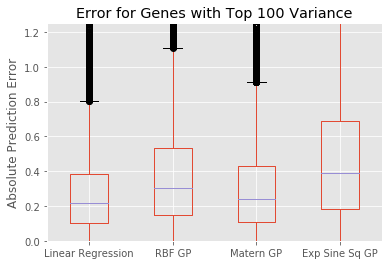

In [560]:
pd.DataFrame([lr_error, rbf_error, matern_error, exp_sine_sq_error], index=["Linear Regression", "RBF GP", "Matern GP", "Exp Sine Sq GP"]).transpose().boxplot()
plt.title("Error for Genes with Top " + str(num_genes) + " Variance")
plt.ylabel("Absolute Prediction Error")
plt.ylim([0,1.25])
plt.savefig("plots/gp_3.png", dpi=300)
print("LR vs RBF")
print(scipy.stats.ranksums(lr_error, rbf_error))
print("LR vs Matern")
print(scipy.stats.ranksums(lr_error, matern_error))
print("LR vs Exp-Sine-Sq")
print(scipy.stats.ranksums(lr_error, exp_sine_sq_error))
plt.savefig("plots/fig_6.png", dpi=300)

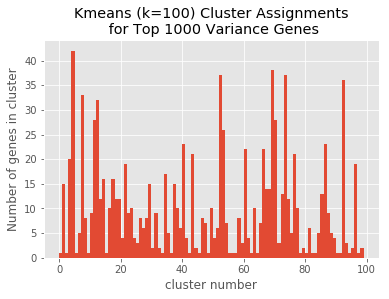

In [573]:
df = pd.read_csv(args.design_matrix)
df.set_index("Gene_id", inplace=True)
df = df.transpose()

df = df[original_df.var().nlargest(1000).index]
clusters = 100

kmeans = KMeans(n_clusters=clusters, random_state=0).fit(df.transpose())
plt.hist(kmeans.labels_, bins=range(clusters))
plt.title("Kmeans (k=100) Cluster Assignments\n for Top 1000 Variance Genes")
plt.xlabel("cluster number")
plt.ylabel("Number of genes in cluster")
plt.savefig("plots/fig_4.png", dpi=300)

In [574]:
kmeans_assignments = {}
for i in range(clusters):
    cluster_index = []
    for j in range(len(kmeans.labels_)):
        if kmeans.labels_[j] == i:
            cluster_index.append(j)
    kmeans_assignments[i] = cluster_index
    
clustered_df = pd.DataFrame([], index=df.index, columns=range(100))
for i in range(clusters):
    clustered_df[i] = df.transpose().iloc[kmeans_assignments[i]].mean()
df = clustered_df
    
lr_error = []
rbf_error = []
matern_error = []
exp_sine_sq_error = []

# Iterate over all genes 
for gene in df:
    print(gene)
    for test_index, test_val in df[gene].iteritems():
        train_index = get_train_index(test_index)
        train_time = np.array(index_to_time(train_index)).reshape(-1, 1)
        train_val = df[gene][train_index].as_matrix().reshape(-1, 1)
        test_time = index_to_time(test_index)

        lr = linear_model.LinearRegression().fit(train_time, train_val)
        lr_pred = lr.predict(test_time)
        lr_error.append(abs(float(lr_pred) - test_val))

        rbf_gp = GaussianProcessRegressor(kernel=RBF()).fit(train_time, train_val)
        rbf_pred = rbf_gp.predict(test_time)
        rbf_error.append(abs(float(rbf_pred) - test_val))
        
        matern_gp = GaussianProcessRegressor(kernel=Matern()).fit(train_time, train_val)
        matern_pred = matern_gp.predict(test_time)
        matern_error.append(abs(float(matern_pred) - test_val))

        exp_sine_sq_gp = GaussianProcessRegressor(kernel=ExpSineSquared()).fit(train_time, train_val)
        exp_sine_sq_pred = exp_sine_sq_gp.predict(test_time)
        exp_sine_sq_error.append(abs(float(exp_sine_sq_pred) - test_val))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


LR vs RBF
RanksumsResult(statistic=-35.177347375836113, pvalue=4.4400952262659357e-271)
LR vs Matern
RanksumsResult(statistic=-9.8632347581647526, pvalue=6.0081932058858618e-23)
LR vs Exp-Sine-Sq
RanksumsResult(statistic=-49.556586719110541, pvalue=0.0)


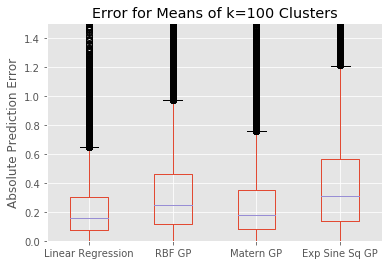

In [575]:
pd.DataFrame([lr_error, rbf_error, matern_error, exp_sine_sq_error], index=["Linear Regression", "RBF GP", "Matern GP", "Exp Sine Sq GP"]).transpose().boxplot()
plt.title("Error for Means of k=" + str(clusters) + " Clusters")
plt.ylabel("Absolute Prediction Error")
plt.ylim([0,1.5])
plt.savefig("plots/gp_5.png", dpi=300)
print("LR vs RBF")
print(scipy.stats.ranksums(lr_error, rbf_error))
print("LR vs Matern")
print(scipy.stats.ranksums(lr_error, matern_error))
print("LR vs Exp-Sine-Sq")
print(scipy.stats.ranksums(lr_error, exp_sine_sq_error))
plt.savefig("plots/fig_7.png", dpi=300)

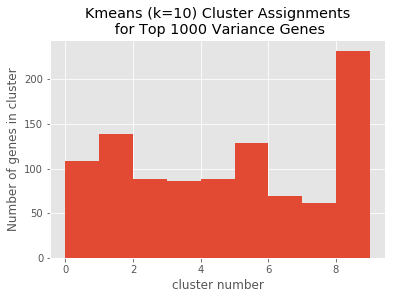

In [566]:
df = pd.read_csv(args.design_matrix)
df.set_index("Gene_id", inplace=True)
df = df.transpose()

df = df[original_df.var().nlargest(1000).index]
clusters = 10
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(df.transpose())
plt.hist(kmeans.labels_, bins=range(clusters))
plt.title("Kmeans (k=10) Cluster Assignments\n for Top 1000 Variance Genes")
plt.xlabel("cluster number")
plt.ylabel("Number of genes in cluster")
plt.savefig("plots/fig_5.png", dpi=300)

In [567]:
kmeans_assignments = {}
for i in range(clusters):
    cluster_index = []
    for j in range(len(kmeans.labels_)):
        if kmeans.labels_[j] == i:
            cluster_index.append(j)
    kmeans_assignments[i] = cluster_index
    
clustered_df = pd.DataFrame([], index=df.index, columns=range(10))
for i in range(clusters):
    clustered_df[i] = df.transpose().iloc[kmeans_assignments[i]].mean()
df = clustered_df
    
lr_error = []
rbf_error = []
matern_error = []
exp_sine_sq_error = []

# Iterate over all genes 
for gene in df:
    print(gene)
    for test_index, test_val in df[gene].iteritems():
        train_index = get_train_index(test_index)
        train_time = np.array(index_to_time(train_index)).reshape(-1, 1)
        train_val = df[gene][train_index].as_matrix().reshape(-1, 1)
        test_time = index_to_time(test_index)

        lr = linear_model.LinearRegression().fit(train_time, train_val)
        lr_pred = lr.predict(test_time)
        lr_error.append(abs(float(lr_pred) - test_val))

        rbf_gp = GaussianProcessRegressor(kernel=RBF()).fit(train_time, train_val)
        rbf_pred = rbf_gp.predict(test_time)
        rbf_error.append(abs(float(rbf_pred) - test_val))
        
        matern_gp = GaussianProcessRegressor(kernel=Matern()).fit(train_time, train_val)
        matern_pred = matern_gp.predict(test_time)
        matern_error.append(abs(float(matern_pred) - test_val))

        exp_sine_sq_gp = GaussianProcessRegressor(kernel=ExpSineSquared()).fit(train_time, train_val)
        exp_sine_sq_pred = exp_sine_sq_gp.predict(test_time)
        exp_sine_sq_error.append(abs(float(exp_sine_sq_pred) - test_val))

0
1
2
3
4
5
6
7
8
9


LR vs RBF
RanksumsResult(statistic=-18.821354041541408, pvalue=5.0477957808974038e-79)
LR vs Matern
RanksumsResult(statistic=-4.752621166220198, pvalue=2.0079636243815251e-06)
LR vs Exp-Sine-Sq
RanksumsResult(statistic=-25.131719375437331, pvalue=2.2393135509792892e-139)


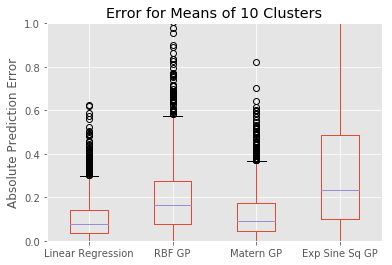

In [570]:
pd.DataFrame([lr_error, rbf_error, matern_error, exp_sine_sq_error], index=["Linear Regression", "RBF GP", "Matern GP", "Exp Sine Sq GP"]).transpose().boxplot()
plt.title("Error for Means of " + str(clusters) + " Clusters")
plt.ylabel("Absolute Prediction Error")
plt.ylim([0,1])
plt.savefig("plots/cluster_10.png", dpi=300)
print("LR vs RBF")
print(scipy.stats.ranksums(lr_error, rbf_error))
print("LR vs Matern")
print(scipy.stats.ranksums(lr_error, matern_error))
print("LR vs Exp-Sine-Sq")
print(scipy.stats.ranksums(lr_error, exp_sine_sq_error))
plt.savefig("plots/fig_8.png", dpi=300)